# **Transfer Learning with VGG 16**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**

* STL-10 Dataset (STL: Stanford, Toronto, and Leipzig)
    * Image dataset containing images of size 96x96 pixels
    * Consists of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, and truck
    * Total of 5,000 labeled images for training and 8,000 labeled images for testing
    * Each class has 500 training images and 800 testing images
    * Additionally includes an unlabeled dataset of 100,000 images
    * Commonly used for unsupervised learning, semi-supervised learning, and transfer learning tasks
    * Images collected from labeled datasets from ImageNet and manually annotated
    * Freely available for research purposes

_________________________
**Accessing Dataset**

In [1]:
cd ..

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning


In [2]:
cd datasets

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning/datasets


___________

In [3]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import summary libraries for model information
from torchsummary import summary

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# import torchvision and transformations libraries
import torchvision as tv
import torchvision.transforms as T

In [4]:
# use if GPU is available 
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
# Import a dataset

### Note that resnet is trained for images in a specific range of pixel values not [-1,1]

# transformations
transform=T.Compose([ 
    T.ToTensor(), # normalizes the image to range [0,1]
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]
)

# import the data and simultaneously apply the transform
trainset=tv.datasets.STL10(root='./stl10',download=True,split='train',transform=transform)
testset=tv.datasets.STL10(root='./stl10',download=True,split='test',transform=transform)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(testset,batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# check out the shape of the datasets
print("Data shapes (train/test):")
print(f"{trainset.data.shape}")
print(f"{testset.data.shape}")

# and average the range of pixel intensity values
print('\nData value range')
print((np.min(trainset.data),np.max(trainset.data)))

# print the unique categories
print('\nData categories')
print(trainset.classes)

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range
(0, 255)

Data categories
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [7]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x96x96
# and they are not normalized 

# but ..
X,y=next(iter(train_loader))

# try again 
print("Data shapes (train/test):")
print(f"{X.data.shape}")

# and average the range of pixel intensity values
print('\nData value range')
print((tr.min(X.data),tr.max(X.data)))

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range
(tensor(-2.1179), tensor(2.6400))


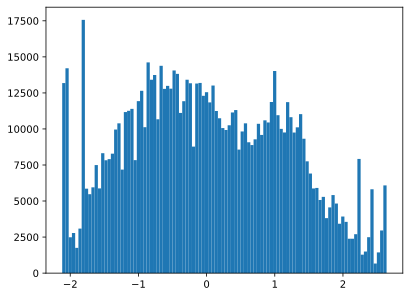

In [8]:
# histogram of the data 
plt.hist(X.data.numpy().flatten(),100);  

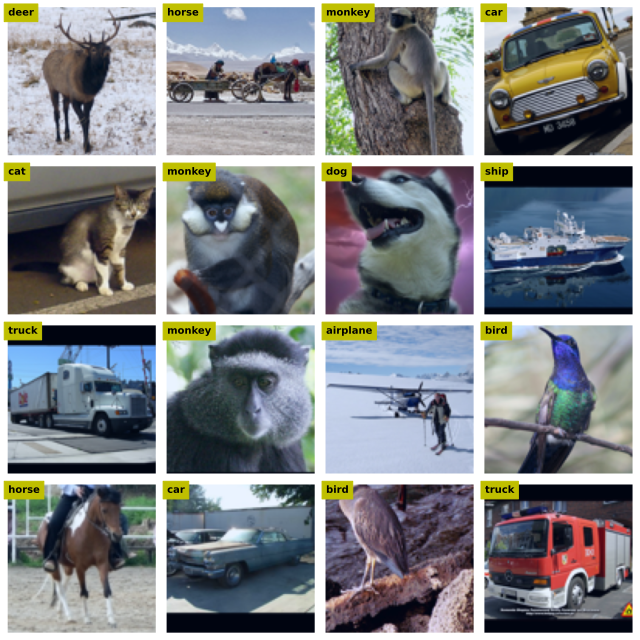

In [9]:
# inspect a few random images 
fig,axs=plt.subplots(4,4,figsize=(9,9))

for (i,ax) in enumerate(axs.flatten()):
  # extract the image (need to transpose it back to 96x96x3)
  pic=X.data[i].numpy().transpose((1,2,0))
  pic=(pic-np.min(pic))/(np.max(pic)-np.min(pic))

  # and its label
  label=trainset.classes[y[i]]

  # and show
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# import and inspect the resnet model
from torchvision.models import vgg16, VGG16_Weights
vgg = vgg16(weights=VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/rudraksha14/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


In [12]:
# lets inspect the network
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
summary(vgg.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [14]:
# freeze all layers (final layer changed later)
for p in vgg.parameters():
    p.requires_grad=False

    # python note: the above operation can be implemented in-line
    # p.requires_grad_(False)

In [15]:
# change the final layer
# change the final layer (this time soft-coded!)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features,10)

In [16]:
# push the model to the GPU (if using)
vgg.to(device);

In [17]:
# Train the model
lossfun=nn.CrossEntropyLoss()
optimizer=tr.optim.SGD(vgg.parameters(),lr=0.01,momentum=0.9)

In [18]:
numepochs=10

# initialize losses
trainLoss=tr.zeros(numepochs)
testLoss=tr.zeros(numepochs)
trainAcc=tr.zeros(numepochs)
testAcc=tr.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over the training data batches 
    vgg.train()  # switch to train mode
    batchLoss=[]
    batchAcc=[]

    for X,y in train_loader:

        # push data to GPU
        X=X.to(device)
        y=y.to(device)

        # forward pass and loss
        yHat=vgg(X)
        loss=lossfun(yHat,y)

        # backprop  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch 
        batchLoss.append(loss.item())
        batchAcc.append(tr.mean((tr.argmax(yHat,axis=1)==y).float()).item())
        
        # end of batch loop

    # and get the average losses and accuracies across the batches
    trainLoss[epochi]=np.mean(batchLoss)
    trainAcc[epochi]=100*np.mean(batchAcc)

    ### test performance (here done in batches)
    vgg.eval() # switch to test mode
    batchAcc=[]
    batchLoss=[]
    for X,y in test_loader:
        # push the data to GPU
        X=X.to(device)
        y=y.to(device)

        # forward pass and loss
        with tr.no_grad():
            yHat=vgg(X)
            loss=lossfun(yHat,y)

        # loss and accuracy from this batch 
        batchLoss.append(loss.item())
        batchAcc.append(tr.mean((tr.argmax(yHat,axis=1)==y).float()).item())
    # end of batch loop
        
    # and get the average losses and accuracies across the batches
    testLoss[epochi]=np.mean(batchLoss)
    testAcc[epochi]=100*np.mean(batchAcc)

    print(f'{epochi+1}/{numepochs} completed!!!. Test Accuracy={testAcc[epochi]:.2f}%')

1/10 completed!!!. Test Accuracy=89.97%
2/10 completed!!!. Test Accuracy=90.28%
3/10 completed!!!. Test Accuracy=90.89%
4/10 completed!!!. Test Accuracy=90.17%
5/10 completed!!!. Test Accuracy=91.44%
6/10 completed!!!. Test Accuracy=90.08%
7/10 completed!!!. Test Accuracy=91.20%
8/10 completed!!!. Test Accuracy=90.55%
9/10 completed!!!. Test Accuracy=90.98%
10/10 completed!!!. Test Accuracy=91.13%


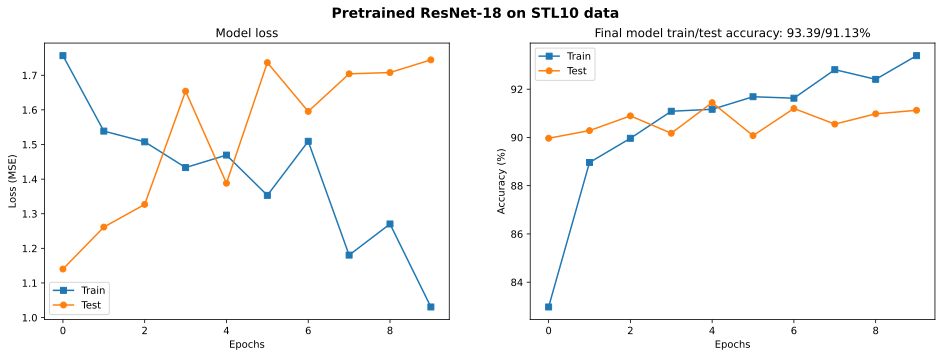

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

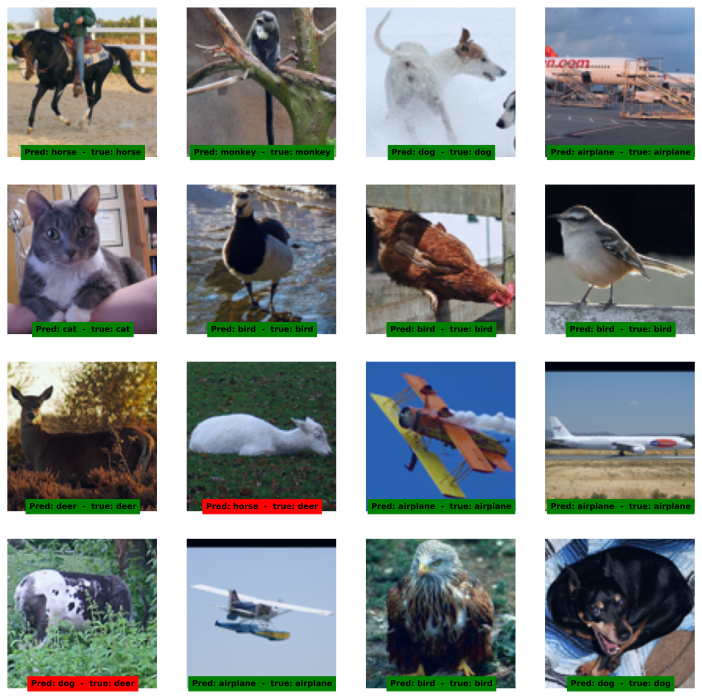

In [20]:
# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
vgg.eval()
predictions = tr.argmax( vgg(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  # show the image
  ax.imshow(pic)
  
  
  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()